# 1. Subcellular localization module

This colab sheet shows how to perform proteins data mining from Uniprot, with the aim to develop a machine learning model capables of predict the subcellular localization of unseen proteins. 

a. Proteins and subcellular localization are acquired from Uniprot (https://www.uniprot.org/).
Eucaryotic pathogens in humans are acquired from VEuPathDB (NIH funded) at this website: https://veupathdb.org/veupathdb/app.

b. Preprocessing: only experimental validated proteins are retained (ECO:0000269). Cytosolic proteins are merged with internal membrane ones and secreted proteins are merged with cytoplasmic membrane proteins in order to create a simple ad interpretable binary model.

CD-HIT software (developed by Dr. Weizhong Li at Dr. Adam Godzik's Lab at the Burnham Institute, now Sanford-Burnham Medical Research Institute) is used in order to efficiently cluster proteins. 
This produces a set of 'non-redundant' (nr) representative sequences as output. In addition cd-hit outputs a cluster file, documenting the sequence 'groupies' for each nr sequence representative. The idea is to reduce the overall size of the database without removing any sequence information by only removing 'redundant' (or highly similar) sequences. This is why the resulting database is called non-redundant (nr). Essentially, cd-hit produces a set of closely related protein families from a given fasta sequence database.

Use of CD-HIT is required in order to avoid homology-based biases during the creation of mathematical models using protein sequences. 

c. Feature extraction
d. Models 







- Data mining

In [ ]:
# install biopython

pip install Bio

In [ ]:
# import libraries
import urllib
from Bio import SeqIO
import requests

In [ ]:
# using rest API to obtain secreted, membrane and in_membrane (experimentally annotated) eukaryotic proteins

url_out = 'https://rest.uniprot.org/uniprotkb/stream?compressed=true&fields=accession%2Cid%2Corganism_name%2Clength%2Ccc_subcellular_location%2Csequence&format=tsv&query=%28%28taxonomy_id%3A2759%29%20AND%20%28reviewed%3Atrue%29%20AND%20%28%28cc_scl_term%3ASL-0243%29%20AND%20%28ccev_scl_term%3AECO_0000269%29%29%29' 
url_mem = 'https://rest.uniprot.org/uniprotkb/stream?fields=accession%2Cid%2Cprotein_name%2Corganism_name%2Clength%2Ccc_subcellular_location%2Csequence&format=tsv&query=%28%28taxonomy_id%3A2759%29%20AND%20%28reviewed%3Atrue%29%20AND%20%28cc_scl_term%3ASL-0310%29%20OR%20%28%28cc_scl_term%3ASL-0039%29%20AND%20%28ccev_scl_term%3AECO_0000269%29%29%20OR%20%28%28cc_scl_term%3ASL-0378%29%20AND%20%28ccev_scl_term%3AECO_0000269%29%29%20OR%20%28%28cc_scl_term%3ASL-0375%29%20AND%20%28ccev_scl_term%3AECO_0000269%29%29%29'
in_mem_url = 'https://rest.uniprot.org/uniprotkb/stream?fields=accession%2Cid%2Cprotein_name%2Corganism_name%2Clength%2Ccc_subcellular_location%2Csequence&format=tsv&query=%28%28taxonomy_id%3A2759%29%20AND%20%28reviewed%3Atrue%29%20AND%20%28cc_scl_term%3ASL-0182%29%20OR%20%28%28cc_scl_term%3ASL-0171%29%20AND%20%28ccev_scl_term%3AECO_0000269%29%29%20OR%20%28%28cc_scl_term%3ASL-0134%29%20AND%20%28ccev_scl_term%3AECO_0000269%29%29%20OR%20%28%28cc_scl_term%3ASL-0271%29%20AND%20%28ccev_scl_term%3AECO_0000269%29%29%20OR%20%28%28cc_scl_term%3ASL-0157%29%20AND%20%28ccev_scl_term%3AECO_0000269%29%29%29'

In [ ]:
#in = download from uniprot website. max api capacity=10.000 proteins

#include sublocation terms: vacuole, lysosome, cytoplasm, cytosol, mitochondria,
# nucleus, nucleolus, golgi apparatus

In [ ]:
# using requests module to make a request to uniprot web page.
# see https://www.w3schools.com/python/module_requests.asp for more info

secreted_proteins_eu = requests.get(url_out).text
membrane_proteins_eu = requests.get(url_mem).text
in_mem_eu = requests.get(in_mem_url).text

In [ ]:
with requests.get(url_out, stream=True) as request:
    request.raise_for_status()
    with open('out.csv', 'wb') as f:
        for chunk in request.iter_content(chunk_size=2**20):
            f.write(chunk)

In [ ]:
with requests.get(url_mem, stream=True) as request:
    request.raise_for_status()
    with open('mem.csv', 'wb') as f:
        for chunk in request.iter_content(chunk_size=2**20):
            f.write(chunk)

In [ ]:
with requests.get(in_mem_url, stream=True) as request:
    request.raise_for_status()
    with open('in_mem.csv', 'wb') as f:
        for chunk in request.iter_content(chunk_size=2**20):
            f.write(chunk)

- Preprocessing

In [ ]:
import pandas as pd     
import csv

In [ ]:
# Loading .csv files into DataFrame objects 
# It is best to use python engine, UTF-8 encoding and error_bad_lines = False to avoid loading problems 

df_in = pd.read_csv('in.csv', header=0, sep="\t", engine='python', encoding='utf-8', error_bad_lines=False,
                             quoting=csv.QUOTE_NONE)
df_out = pd.read_csv('out.csv', header=0, sep="\t", engine='python', encoding='utf-8', error_bad_lines=False,
                             quoting=csv.QUOTE_NONE, compression='gzip')
df_mem = pd.read_csv('mem.csv', header=0, sep="\t", engine='python', encoding='utf-8', error_bad_lines=False,
                             quoting=csv.QUOTE_NONE)
df_in_mem = pd.read_csv('in_mem.csv', header=0, sep="\t", engine='python', encoding='utf-8', error_bad_lines=False,
                             quoting=csv.QUOTE_NONE)

In [ ]:
df_in.shape

(49976, 6)

In [ ]:
df_out.shape

(7017, 6)

In [ ]:
df_mem.shape

(7205, 7)

In [ ]:
df_in_mem.shape

(4020, 7)

It was chosen to use only experimental validated proteins from Uniprot ---> ECO:0000269. for more informations visit https://www.uniprot.org/help/evidences

In [ ]:
def selector(x):
    if '0000269' in x:
        return 'validated'
    else:
        pass

We need to labels acquired proteins

In [ ]:
df_in = df_in.copy()
df_in['Subcellular location ext'] = df_in['Subcellular location [CC]'].apply(selector)

df_in = df_in.dropna()
df_in.to_csv('in.csv', sep='\t', index=False)

In [ ]:
df_out = df_out.copy()
df_out['Subcellular location ext'] = df_out['Subcellular location [CC]'].apply(selector)

df_out = df_out.dropna()
df_out.to_csv('out.csv', sep='\t', index=False)

In [ ]:
df_mem = df_mem.copy()
df_mem['Subcellular location ext'] = df_mem['Subcellular location [CC]'].apply(selector)

df_mem = df_mem.dropna()
df_mem.to_csv('mem.csv', sep='\t', index=False)

In [ ]:
df_in_mem = df_in_mem.copy()
df_in_mem['Subcellular location ext'] = df_in_mem['Subcellular location [CC]'].apply(selector)

df_in_mem = df_in_mem.dropna()
df_in_mem.to_csv('in_mem.csv', sep='\t', index=False)

In [ ]:
df_in = pd.read_csv('in.csv', header=0, sep='\t')
df_out = pd.read_csv('out.csv', header=0, sep='\t')
df_mem = pd.read_csv('mem.csv', header=0, sep='\t')
df_in_mem = pd.read_csv('in_mem.csv', header=0, sep='\t')

In [ ]:
df_in['location'] = 'in'
df_out['location'] = 'out'
df_mem['location'] = 'mem'
df_in_mem['location'] = 'in_mem'

In [ ]:
df_mem = df_mem.drop(columns='Protein names')
df_in_mem = df_in_mem.drop(columns='Protein names')

Concatenate protein databases

In [ ]:
frames = [df_in, df_out, df_mem, df_in_mem]

result = pd.concat(frames)

In [ ]:
result.to_csv('allproteins.csv', sep='\t', index=False)

In [ ]:
result.shape

(39576, 8)

Remove commas using calc or with python. Datasets downloaded from Uniprot can contain commas who can interfere with the right number of columns.

In [ ]:
df = pd.read_csv('allproteins.csv', header=0, sep='\t')
df.to_csv('allprot.csv', sep=',', index=False)

In [ ]:
df.shape

(39576, 10)

In order to perform clustering of proteins, we need to convert .csv file into .fasta file (input format accepted by cd-hit).

In [ ]:
!awk -F , '{print ">"$2"\n"$6}' allprot.csv > sequences.fasta #2 --> entry name, 6--> sequence

Remove first two lines (header)

In [ ]:
with open('sequences.fasta', 'r') as fin:
  data = fin.read().splitlines(True)
with open('sequences.fasta', 'w') as fout:
  fout.writelines(data[2:])

CD_HIT 25% similarity ---> proteins were clusterized in order to remove redundant ones (>25% similarity). 
Resultant dataset has no homology-based biases that could create biases-models. 

cd-hit package is not available via a python library, so you need visit https://github.com/weizhongli/cdhit-web-server and use docker platform.

- generated file by cd-hit is called 'all25.fasta'

In [ ]:
import sys 
from Bio import SeqIO 

In [ ]:
fasta_file = 'all25.fasta' 
ids = []
seq = []
for seq_record in SeqIO.parse(fasta_file, "fasta"): 
  ids.append(seq_record.id)
  seq.append(str(seq_record.seq))

In [ ]:
res = dict(zip(ids, seq))

In [ ]:
with open('all25.csv', 'w') as csv_file:  
    writer = csv.writer(csv_file)
    for key, value in res.items():
       writer.writerow([key, value])

compare all25.csv with allprot.csv to retrieve representative proteins sequences and target column (location)

In [ ]:
df_all25 = pd.read_csv('all25.csv', sep=',')
df_allprot = pd.read_csv('allprot.csv')

In [ ]:
df_all25.shape

(15840, 2)

In [ ]:
df_allprot.shape

(39576, 8)

In [ ]:
df_all25.columns = ['Entry Name', 'Sequence']  

In [ ]:
df_common = pd.merge(df_all25, df_allprot, how='inner')

In [ ]:
df_common.shape

(18455, 8)

In [ ]:
df_common.to_csv('allproteins25common.csv', sep=',', index=False)

- Training set creation from veupathdb 

- Only proteins from organisms who appear in veupathdb were used for the training process. 

In [ ]:
df_common = pd.read_csv('allproteins25common.csv')

In [ ]:
df_common.drop(columns=df_common.columns[0], axis=1, inplace=True)

In [ ]:
df_common

In [ ]:
df_common.shape

(18455, 11)

In [ ]:
# read veupathdb file
df_organisms = pd.read_csv('organisms.csv')

In [ ]:
# shape[0] shows organisms number
df_organisms.shape

(646, 29)

It is important removing host organisms and vector organisms. we set the appropriate index and then we remove all vector based organisms using the drop pandas function with the help of the labels parameter.

In [ ]:
df_organisms_index = df_organisms.set_index('VEuPathDB Project')

In [ ]:
#removes organisms that are from VectorBase module of VEUpathDB database
organisms_of_interest_df1 = df_organisms_index.drop(labels='HostDB', axis=0)
organisms_of_interest_df = organisms_of_interest_df1.drop(labels='VectorBase', axis=0).reset_index(drop=False)

In [ ]:
# final number of organisms to consider
organisms_of_interest_df.shape

(577, 29)

In [ ]:
organisms_list = list(organisms_of_interest_df['Species'])

In [ ]:
if 'Homo sapiens' in organisms_list:    #check
  print('true')
else:
  print('no')

no


Now we need to compare pathogenic organisms from veupathdb with all proteins acquired from Uniprot in order to utilize only eucaryotic proteins derived from pathogenic organisms from nih database.

In [ ]:
#retains only first two words in 'Organism' column, mandatory to compare the column with organisms of interests list
df_common['Organism'] = df_common['Organism'].apply(lambda x : ' '.join(x.split()[:1]))   #2

In [ ]:
organisms_list = [x.split()[0] for x in organisms_list]

In [ ]:
df_training = df_common.loc[df_common['Organism'].isin(organisms_list).reset_index(drop=True)]
df_training.to_csv('training_set.csv')

In [ ]:
df_common.shape

(18455, 11)

In [ ]:
df_training.shape

(14123, 11)

In [ ]:
df_training = pd.read_csv('training_set.csv')

In [ ]:
# show number of proteins relative to every label
df_training['location'].value_counts()

In order to make the model more easier and interpretable, we decided to merge in_mem-in and out-mem proteins. But it is important creating a balanced dataset. 
Since we have a huge number of internal proteins respect to other labels, we need to sample our dataset extracting the same number of proteins from every dataset in a randomized approach.

In [ ]:
out_sample1 = df_validation[df_validation['location'] == 'in'].sample(n=201, replace=False, random_state=42)


In [ ]:
out_sample2 = df_validation[df_validation['location'] == 'out'].sample(n=201, replace=False, random_state=42)

In [ ]:
out_sample3 = df_validation[df_validation['location'] == 'mem'].sample(n=202, replace=False, random_state=42)

In [ ]:
out_sample4 = df_validation[df_validation['location'] == 'in_mem'].sample(n=202, replace=False, random_state=42)

In [ ]:
# concatenate datasets
df_sample = pd.concat([out_sample2, out_sample1, out_sample3, out_sample4])

For the purpose of creating a simple and more interpretable mathematical model, we decided to merge in-in_mem and out-mem proteins.

In [ ]:
df_sample['location'] = df_sample['location'].replace({'in_mem': 'in', 'mem': 'out'})

In [ ]:
df_sample

In [ ]:
df_sample['location'].value_counts()

out    403
in     403
Name: location, dtype: int64

Now, we need to define target variable (y) that contains protein localization labels (the last column in our dataset).

In [ ]:
y = df_sample.iloc[:,-1]

In [ ]:
y

4023       out
3930       out
3948       out
4098       out
4060       out
         ...  
943     in_mem
3638    in_mem
768     in_mem
743     in_mem
1784    in_mem
Name: location, Length: 806, dtype: object

In [ ]:
df_sample.to_csv('allproteins25common.csv', sep=',', index=False)

- Feature extraction with iFeature
iFeature is a python package capables of extract mathematical and physical-chemical descriptors from protein sequences. For a in-depth knowledge of the package, please visit https://github.com/Superzchen/iFeature.

In [ ]:
#!awk -F , '{print ">"$1"\n"$2}' training_set.csv > training_set.fasta
!awk -F , '{print ">"$2"\n"$3}' allproteins25common.csv > training.fasta

In [ ]:
with open('training.fasta', 'r') as fin:
  data = fin.read().splitlines(True)
with open('training.fasta', 'w') as fout:
  fout.writelines(data[2:])

In [ ]:
with open('validation_set.fasta', 'r') as fin:
  data = fin.read().splitlines(True)
with open('validation_set.fasta', 'w') as fout:
  fout.writelines(data[2:])

In [ ]:
# clone iFeature library from github
!git clone https://github.com/Superzchen/iFeature  

In [ ]:
# Descriptors calculation for the training set
!python iFeature/iFeature.py --file training_set.fasta --type AAC --out AAC.csv   #1 aa composition (frequency), 20 features
!python iFeature/iFeature.py --file training_set.fasta --type DPC --out DPC.csv   #2 DPC (dipeptide composition), 400 features
#!python iFeature/iFeature.py --file training_set.fasta --type TPC --out TPC.csv   #3 TPC  
!python iFeature/iFeature.py --file training_set.fasta --type DDE --out DDE.csv   #4 dipeptide deviation from expected mean (DDE)
!python iFeature/iFeature.py --file training_set.fasta --type GAAC --out GAAC.csv #5 GAAC grouped aminoacid composition, 5 features
!python iFeature/iFeature.py --file training_set.fasta --type GDPC --out GDPC.csv #6 GDPC
!python iFeature/iFeature.py --file training_set.fasta --type GTPC --out GTPC.csv #7 GTPC
!python iFeature/iFeature.py --file training_set.fasta --type CTDC --out CTDC.csv #8 CTDC
!python iFeature/iFeature.py --file training_set.fasta --type CTDT --out CTDT.csv #9 CTDT
!python iFeature/iFeature.py --file training_set.fasta --type CTDD --out CTDD.csv #10 CTDD

Descriptor type: AAC
Descriptor type: DPC
Descriptor type: DDE
Descriptor type: GAAC
Descriptor type: GDPC
Descriptor type: GTPC
Descriptor type: CTDC
Descriptor type: CTDT
Descriptor type: CTDD


In [ ]:
import numpy as np

In [ ]:
def data2vecloc(fasta_file):
    """This function takes as input iFeature descriptors and concat them"""
    

    proteins = list(SeqIO.parse(fasta_file, "fasta"))

    extension = ".csv"
    files = ["AAC", "DPC", "DDE", "GAAC", "GDPC", 'GTPC', 'CTDC', 'CTDT', 'CTDD']

    datasets = [[] for el in files]
    for i in range(len(files)):
        with open(files[i] + extension) as f:
            lines = f.readlines()[1:]
            check_prot = 0
            for line in lines:
                information = line.split('\t')

                if not information[0] == proteins[check_prot].id:
                    print("Error in protein order! Return")

                    return datasets

                # Aggiunta della lunghezza proteica come ultima colonna
                length = float(information[-1].rstrip())
                datasets[i].append(np.array([float(el) for el in information[1:-1]] + [length]))
                check_prot += 1
        datasets[i] = np.array(datasets[i])
    return datasets



In [ ]:
datasets = data2vecloc('training_set.fasta')

In [ ]:
datasets

In [ ]:
def load_fasta_file(fasta_file):
    """the function loads fasta file and return id and associated sequence for every protein in the file"""
    sequences = []
    sequence_ids = []
    with open(fasta_file) as f:
        for line in f:
            line = line.strip()
            if line.startswith(">"):
                sequence_ids.append(line[1:])
            else:
                sequences.append(line)
    return sequence_ids, sequences

In [ ]:
sequence_ids, sequence= load_fasta_file('training_set.fasta')

In [ ]:
def preprocessingloc(fasta_file, sequence_ids):
    """function to define X (independent) variable"""
    datasets = data2vecloc(fasta_file)

    rows = 0
    n = len(sequence_ids)
    rows = n
    columns = 0
    num_descriptors = []
    for i in range(len(datasets)):
        tmp_dim = datasets[i].shape[1]

        columns += tmp_dim
        num_descriptors.append(i + 1)
    num_descriptors = (len(num_descriptors))

    X = np.zeros((rows, columns))
    for i in range(n):
        X[i] = np.concatenate([datasets[j][i] for j in range(num_descriptors)])
    return X

In [ ]:
X = preprocessingloc('training_set.fasta', sequence_ids)

In [ ]:
X

array([[8.18713450e-02, 1.52046784e-02, 6.90058480e-02, ...,
        5.16959064e+01, 7.40350877e+01, 9.98830409e+01],
       [1.36054422e-01, 0.00000000e+00, 4.76190476e-02, ...,
        4.14965986e+01, 8.36734694e+01, 1.00000000e+02],
       [7.21868365e-02, 2.12314225e-02, 7.85562633e-02, ...,
        4.92569002e+01, 7.77070064e+01, 1.00000000e+02],
       ...,
       [1.03004292e-01, 1.28755365e-02, 4.29184549e-02, ...,
        4.84978541e+01, 7.59656652e+01, 9.82832618e+01],
       [7.09677419e-02, 1.29032258e-02, 4.51612903e-02, ...,
        3.41935484e+01, 6.00000000e+01, 9.48387097e+01],
       [6.08695652e-02, 8.69565217e-03, 1.73913043e-02, ...,
        4.17391304e+01, 6.43478261e+01, 9.91304348e+01]])

- Models

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import tqdm
from tqdm.notebook import tqdm
from sklearn.model_selection import RepeatedStratifiedKFold
from scipy.stats import loguniform
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import classification_report

- split dataset in the training and validation sets 

In [ ]:
test_size = 0.2

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Dimensioni set di addestramento: (644, 1248) (644,)
Dimensioni set di test: (162, 1248) (162,)


- Random Forest based model

In [ ]:
# initialize Random Forest
model = RandomForestClassifier(n_jobs=-1, class_weight='balanced')      

model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
# score on the test set
model.score(X_test, y_test) 

0.7716049382716049

- Decision threshold

In [ ]:
probs = model.predict_proba(X_test)

In [ ]:
# configure personalized decision threshold
threshold = 0.40

# from probability to binary preds 
preds = (probs[:,1] > threshold).astype(int)

print("Predictions:", preds)

Predizioni: [0 0 0 1 1 1 0 0 1 0 1 0 0 1 1 0 1 0 1 1 1 1 0 1 1 1 1 0 0 1 1 0 1 1 1 1 0
 1 1 0 0 1 0 0 0 1 0 0 1 1 0 0 0 1 1 0 0 1 1 1 1 1 1 0 1 1 0 1 0 0 0 0 1 0
 1 1 1 0 1 1 0 1 1 0 0 1 0 1 1 0 1 0 1 1 0 0 1 1 0 1 0 1 1 1 0 1 1 1 1 0 1
 1 0 1 1 0 0 1 1 0 0 1 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 0 0 1 0 1 1]


In [ ]:
# labels mapping
label_map = {0: 'in', 1: 'out'}

# from binary values to labels
labels = np.where(preds == 1, 'out', 'in')

print("mapped labels:", labels)

Etichette mappate: ['in' 'in' 'in' 'out' 'out' 'out' 'in' 'in' 'out' 'in' 'out' 'in' 'in'
 'out' 'out' 'in' 'out' 'in' 'out' 'out' 'out' 'out' 'in' 'out' 'out'
 'out' 'out' 'in' 'in' 'out' 'out' 'in' 'out' 'out' 'out' 'out' 'in' 'out'
 'out' 'in' 'in' 'out' 'in' 'in' 'in' 'out' 'in' 'in' 'out' 'out' 'in'
 'in' 'in' 'out' 'out' 'in' 'in' 'out' 'out' 'out' 'out' 'out' 'out' 'in'
 'out' 'out' 'in' 'out' 'in' 'in' 'in' 'in' 'out' 'in' 'out' 'out' 'out'
 'in' 'out' 'out' 'in' 'out' 'out' 'in' 'in' 'out' 'in' 'out' 'out' 'in'
 'out' 'in' 'out' 'out' 'in' 'in' 'out' 'out' 'in' 'out' 'in' 'out' 'out'
 'out' 'in' 'out' 'out' 'out' 'out' 'in' 'out' 'out' 'in' 'out' 'out' 'in'
 'in' 'out' 'out' 'in' 'in' 'out' 'out' 'in' 'out' 'out' 'out' 'out' 'in'
 'out' 'out' 'out' 'out' 'out' 'in' 'out' 'out' 'in' 'out' 'in' 'in' 'out'
 'out' 'out' 'out' 'out' 'out' 'out' 'out' 'out' 'in' 'out' 'out' 'out'
 'out' 'out' 'in' 'in' 'out' 'in' 'out' 'out']


In [ ]:
# print the classification report
print(classification_report(y_test, labels))    

              precision    recall  f1-score   support

          in       0.77      0.63      0.70        76
         out       0.72      0.84      0.77        86

    accuracy                           0.74       162
   macro avg       0.75      0.73      0.73       162
weighted avg       0.75      0.74      0.74       162



In [ ]:
print(classification_report(y_test, y_pred))      #classification report 

              precision    recall  f1-score   support

          in       0.71      0.87      0.78        76
         out       0.86      0.69      0.76        86

    accuracy                           0.77       162
   macro avg       0.78      0.78      0.77       162
weighted avg       0.79      0.77      0.77       162



In [ ]:
# import joblib package to save our model for future use
import joblib

In [ ]:
# save the model
joblib.dump(model, "./euLOC.joblib") 

['./euLOC.joblib']

In [ ]:
#test the model

loaded_rf = joblib.load("./euLOC.joblib")

In [ ]:
loaded_rf.predict(X_test)

array(['in', 'in', 'in', 'out', 'out', 'out', 'in', 'in', 'in', 'in',
       'out', 'in', 'in', 'out', 'out', 'in', 'out', 'in', 'out', 'out',
       'in', 'out', 'in', 'out', 'in', 'out', 'out', 'in', 'in', 'in',
       'out', 'in', 'out', 'out', 'out', 'out', 'in', 'in', 'in', 'in',
       'in', 'in', 'in', 'in', 'in', 'out', 'in', 'in', 'out', 'in', 'in',
       'in', 'in', 'out', 'out', 'in', 'in', 'out', 'in', 'out', 'in',
       'out', 'out', 'in', 'in', 'in', 'in', 'in', 'in', 'in', 'in', 'in',
       'out', 'in', 'in', 'out', 'out', 'in', 'in', 'in', 'in', 'in',
       'out', 'in', 'in', 'out', 'in', 'out', 'in', 'in', 'out', 'in',
       'out', 'out', 'in', 'in', 'out', 'out', 'in', 'in', 'in', 'out',
       'out', 'out', 'in', 'out', 'out', 'out', 'in', 'in', 'out', 'in',
       'in', 'out', 'out', 'in', 'in', 'out', 'out', 'in', 'in', 'out',
       'in', 'in', 'in', 'out', 'in', 'out', 'in', 'in', 'out', 'in',
       'out', 'out', 'in', 'in', 'in', 'in', 'out', 'in', 'in', '

- confusion matrix

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
# make the confusion matrix dataframe
cm = confusion_matrix(y_test.values, y_pred) #normalize='all')     
cm_df = pd.DataFrame(cm,
                     index = ['in', 'out'],
                     columns = ['in', 'out'])

In [ ]:
# Plotting the confusion matrix
def plot_confusion_matrix():
  plt.figure(figsize=(10,8))
  colormap = sns.color_palette("Blues")
  sns.heatmap(cm_df, annot=True, cmap=colormap)
  plt.title('Confusion Matrix')
  plt.ylabel('True Values')
  plt.xlabel('Predicted Values')
  plt.show()

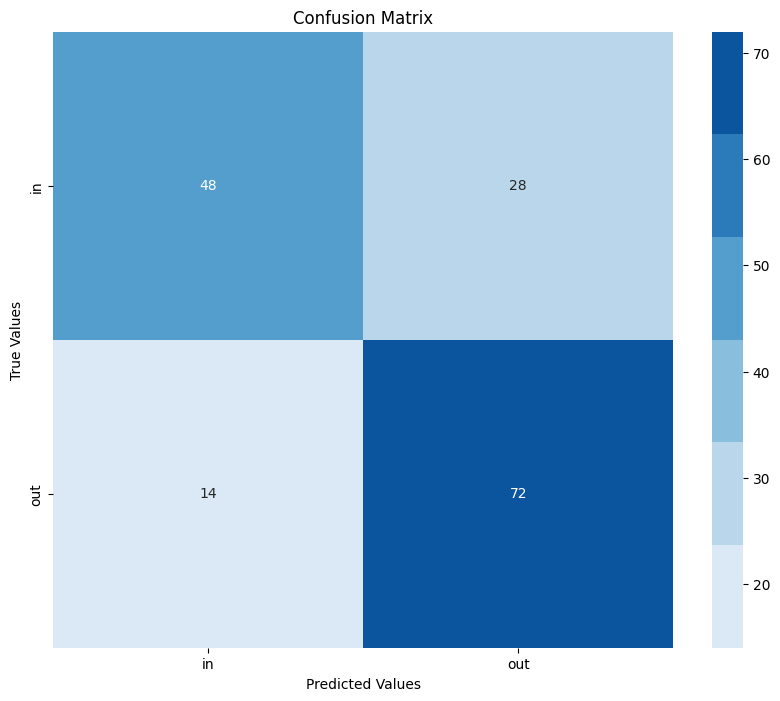

In [ ]:
plot_confusion_matrix()

- Learning curves

In [ ]:
from sklearn.metrics import roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import SVC

In [ ]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=-1,
    scoring=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    scoring : str or callable, default=None
        A str (see model evaluation documentation) or
        a scorer callable object / function with signature
        ``scorer(estimator, X, y)``.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        scoring=scoring,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

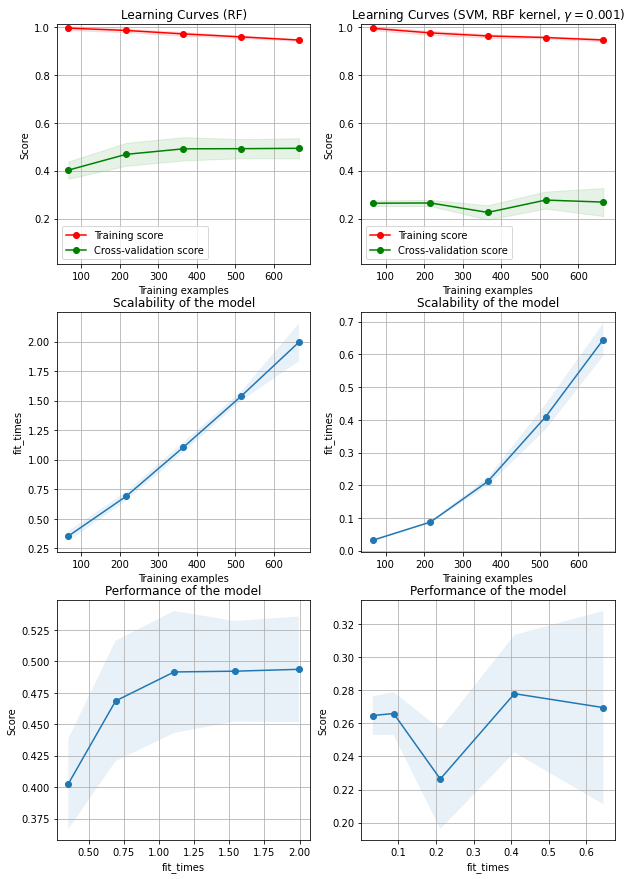

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

title = "Learning Curves (RF)"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=20, test_size=0.1)

estimator = model
plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=axes[:, 0],
    ylim=(0.01, 1.01),
    cv=cv,
    n_jobs=-1,
    scoring="accuracy",
)

title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=5, test_size=0.1)
estimator = SVC(gamma=0.001)
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 1], ylim=(0.01, 1.01), cv=cv, n_jobs=-1
)

plt.show()

- hyperparameters tuning using Weight and Biases


In [ ]:
pip install wandb

In [ ]:
import wandb
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.model_selection import cross_val_score

In [ ]:
with wandb.init(project="RF eNERVE subcell", entity="francesco-patane"):
    val = pd.read_csv('fullval.csv')
    val = full_val.sample(frac=1)
    val = val.groupby('location').apply(lambda x: x.sample(208).reset_index(drop=True))
    val.reset_index(drop=True)
    val.drop(val.columns[len(val.columns)-3], axis=1, inplace=True)
    val.drop(val.columns[len(val.columns)-3], axis=1, inplace=True)
    val.drop(val.columns[len(val.columns)-3], axis=1, inplace=True)
    val.drop(val.columns[len(val.columns)-3], axis=1, inplace=True)
    val = val.reset_index(drop=True)
    X = val.iloc[ :, 0:-1]       #define X
    y = val.iloc[ :, -1:]        #define y
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True) #split in training/validation set



    #--------hyperparameters--------
    wandb.config.n_jobs=-1
    wandb.config.min_samples_split=50
    wandb.config.min_samples_leaf=50
    wandb.config.n_estimators= 100
    wandb.config.max_depth=10
    wandb.config.max_features=0.6
    wandb.config.criterion='entropy'               #'gini' or 'entropy'
    wandb.config.verbose=3
    wandb.config.bootstrap=False
    wandb.config.class_weight=None                    #provare balanced
    wandb.config.min_weight_fraction_leaf=0.0
    wandb.config.max_leaf_nodes=None
    wandb.config.max_samples=None                 #se diverso da None, bootstrap deve essere True
    #--------------------------------
   
    rfc = RandomForestClassifier(
        
        
        max_features = wandb.config.max_features,
        min_samples_leaf = wandb.config.min_samples_leaf,
        min_samples_split = wandb.config.min_samples_split,
        n_estimators = wandb.config.n_estimators,
        n_jobs = wandb.config.n_jobs,
        max_depth = wandb.config.max_depth,
        criterion = wandb.config.criterion,
        verbose = wandb.config.verbose,
        bootstrap = wandb.config.bootstrap,
        class_weight = wandb.config.class_weight,
        min_weight_fraction_leaf = wandb.config.min_weight_fraction_leaf,
        max_leaf_nodes = wandb.config.max_leaf_nodes,
        max_samples = wandb.config.max_samples

   )

    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1)            #cross-validation (5 folds)
    n_scores = cross_val_score(rfc, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise') 

    #rfc.fit(X_train, y_train)
    #y_pred = rfc.predict(X_test)

    #wandb.log({'accuracy': accuracy_score(y_test, y_pred)})
    #wandb.log({'f1': f1_score(y_test, y_pred,average='weighted')})
    #wandb.log({'recall': recall_score(y_test, y_pred, average='weighted')})
    wandb.log({'accuracy': n_scores})


In [ ]:
accuracy = accuracy_score(y_test, preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


Accuracy: 51.19%
